In [1]:
# hide warnings messages
import warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

In [2]:
# read the data
def read_data(filepath):
    """
    Read the parquet file and return the dataframe
    """
    # read parquet file
    df = pd.read_parquet(filepath)

    # calculate the duration of the trip in minutes then round to two decimal places
    df['duration'] = ((df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60)

    # filter for trips that are between 1 and 60 minutes
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    # create a new column for the pickup and dropoff location
    df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)

    return df

In [3]:
# train the model
def train_model(df_train, df_val, model):
    """
    Train the model and return the predictions
    """
    # feature selection
    categorical_features = ['PU_DO']
    numerical_features = ['trip_distance']

    # convert the categorical features to string
    df_train[categorical_features] = df_train[categorical_features].astype(str)

    # initialize the DictVectorizer
    dv = DictVectorizer()

    # training data
    train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    # validation data
    val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
    X_val = dv.transform(val_dict)    

    # target variable
    y_train = df_train['duration'].values
    y_val = df_val['duration'].values

    # train the model
    model.fit(X_train, y_train)

    # predict the duration of the trip
    y_pred = model.predict(X_val)

    return y_pred, y_val, model, dv

In [4]:
def check_distribution(y_pred, y_val):
    """
    Check the distribution of the predictions and the actual values
    """
    sns.distplot(y_pred, label = 'Predictions')
    sns.distplot(y_val, label = 'Actual')
    plt.legend()
    plt.show()

    # calculate mean squared error of RMSE
    print('RMSE: ', mean_squared_error(y_val, y_pred, squared=False))

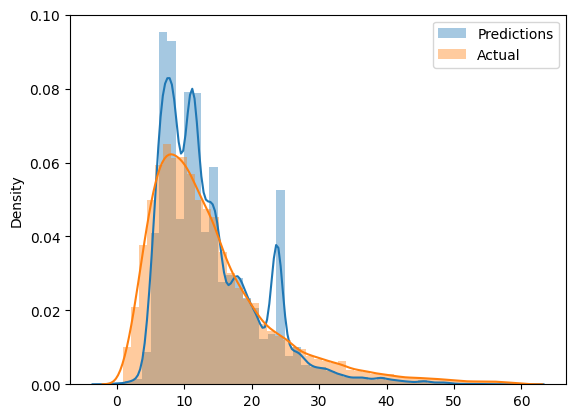

RMSE:  6.037236236897633


In [5]:
# read the data
df_train = read_data('./data/green_tripdata_2023-01.parquet')
df_val = read_data('./data/green_tripdata_2023-02.parquet')

# train the model
y_pred, y_val, model, dv= train_model(df_train, df_val, LinearRegression())

# check the distribution
check_distribution(y_pred, y_val)

In [6]:
# check the number of rows in the training and validation set
len(df_train), len(df_val)

(65946, 62574)

In [7]:
# export the model and the DictVectorizer
with open('./models/lin_reg.bin', 'wb') as f:
    pickle.dump((dv, model), f)